# CITE-seq analysis with totalVI

With totalVI, we can produce a joint latent representation of cells, denoised data for both protein and RNA, integrate datasets, and compute differential expression of RNA and protein. Here we demonstrate this functionality with an integrated analysis of PBMC10k and PBMC5k, datasets of peripheral blood mononuclear cells publicly available from 10X Genomics subset to the 14 shared proteins between them. The same pipeline would generally be used to analyze a single CITE-seq dataset.

If you use totalVI, please consider citing:

* Gayoso, A., Steier, Z., Lopez, R., Regier, J., Nazor, K. L., Streets, A., & Yosef, N. (2021). Joint probabilistic modeling of single-cell multi-omic data with totalVI. Nature Methods, 18(3), 272-282.


In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install
install()

## Imports and data loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scvi
import scanpy as sc

sc.set_figure_params(figsize=(4, 4))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 0
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


This dataset was filtered as described in the totalVI manuscript (low quality cells, doublets, lowly expressed genes, etc.)

In [3]:
adata = scvi.data.pbmcs_10x_cite_seq()
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

INFO     File data/pbmc_10k_protein_v3.h5ad already downloaded                               
INFO     File data/pbmc_5k_protein_v3.h5ad already downloaded                                


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [4]:
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=4000, 
    flavor="seurat_v3",
    batch_key="batch", 
    subset=True,
    layer="counts"
)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [7]:
scvi.model.TOTALVI.setup_anndata(
    adata, 
    protein_expression_obsm_key="protein_expression",
    layer="counts", 
    batch_key="batch"
)

INFO     Using column names from columns of adata.obsm['protein_expression']                 


## Prepare and run model

In [8]:
vae = scvi.model.TOTALVI(adata, latent_distribution="normal")

INFO     Computing empirical prior initialization for protein background.                    


In [9]:
vae.train()

/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/scvi/distributions/_negative_binomial.py:97: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/eecs/jjhong922/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1645690191318/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  + torch.lgamma(x + theta)


Epoch 400/400: 100%|██████████| 400/400 [07:45<00:00,  1.16s/it, loss=1.22e+03, v_num=1]


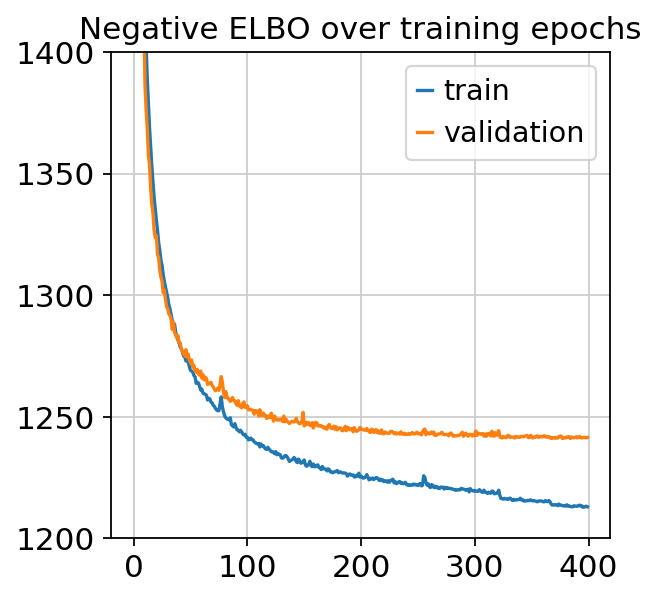

In [10]:
plt.plot(vae.history["elbo_train"], label="train")
plt.plot(vae.history["elbo_validation"], label="validation")
plt.title("Negative ELBO over training epochs")
plt.ylim(1200, 1400)
plt.legend()

## Analyze outputs

We use Scanpy for clustering and visualization after running totalVI. It's also possible to save totalVI outputs for an R-based workflow. First, we store the totalVI outputs in the appropriate slots in AnnData.

In [11]:
adata.obsm["X_totalVI"] = vae.get_latent_representation()

rna, protein = vae.get_normalized_expression(
    n_samples=25, 
    return_mean=True, 
    transform_batch=["PBMC10k", "PBMC5k"]
)

adata.layers["denoised_rna"], adata.obsm["denoised_protein"] = rna, protein

adata.obsm["protein_foreground_prob"] = vae.get_protein_foreground_probability(
    n_samples=25, 
    return_mean=True, 
    transform_batch=["PBMC10k", "PBMC5k"]
)
parsed_protein_names = [p.split("_")[0] for p in adata.obsm["protein_expression"].columns]
adata.obsm["protein_foreground_prob"].columns = parsed_protein_names

Now we can compute clusters and visualize the latent space.

In [12]:
sc.pp.neighbors(adata, use_rep="X_totalVI")
sc.tl.umap(adata, min_dist=0.4)
sc.tl.leiden(adata, key_added="leiden_totalVI")

/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical


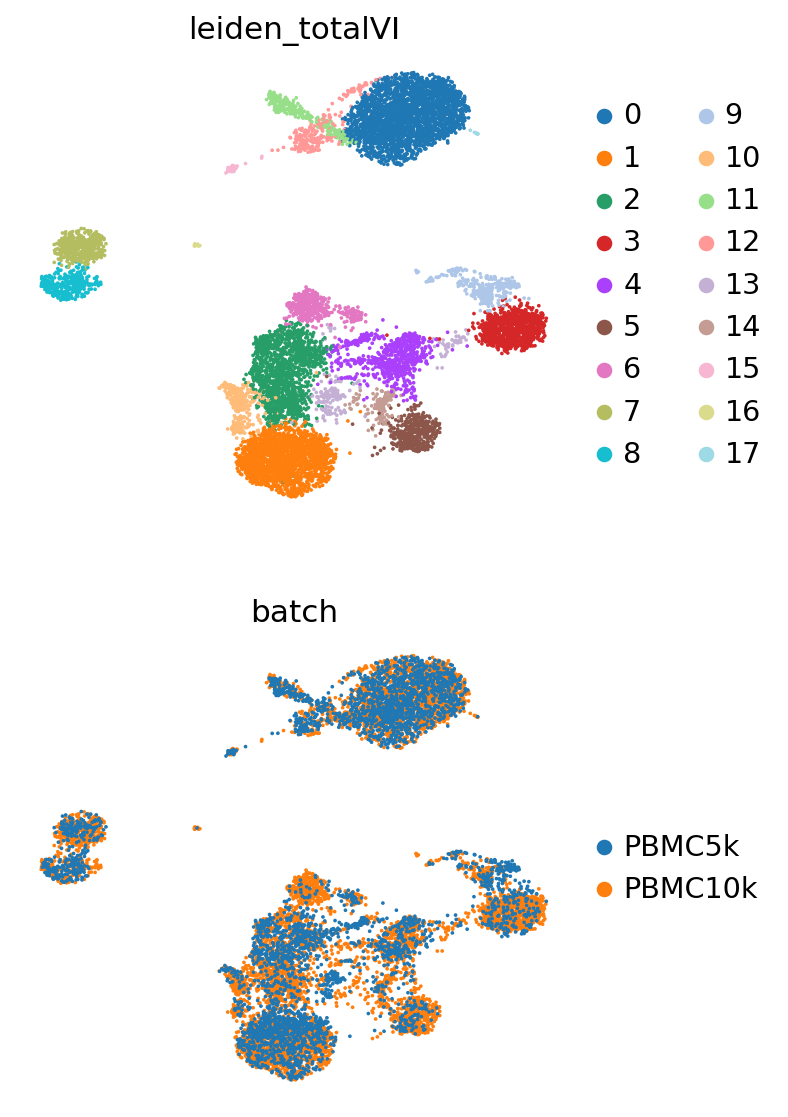

In [13]:
sc.pl.umap(
    adata, 
    color=["leiden_totalVI", "batch"], 
    frameon=False,
    ncols=1,
)

To visualize protein values on the umap, we make a temporary protein adata object. We have to copy over the umap from the original adata object.

In [14]:
pro_adata = sc.AnnData(adata.obsm["protein_expression"].copy(), obs=adata.obs)
sc.pp.log1p(pro_adata)
# Keep log normalized data in raw
pro_adata.raw = pro_adata
pro_adata.X = adata.obsm["denoised_protein"]
# these are cleaner protein names -- "_TotalSeqB" removed
pro_adata.var["protein_names"] = parsed_protein_names
pro_adata.obsm["X_umap"] = adata.obsm["X_umap"]
pro_adata.obsm["X_totalVI"] = adata.obsm["X_totalVI"]


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [15]:
names = adata.obsm["protein_foreground_prob"].columns
for p in names:
    pro_adata.obs["{}_fore_prob".format(p)] = adata.obsm["protein_foreground_prob"].loc[:, p] 

### Visualize denoised protein values 

/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:444: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  pl.colorbar(cax, ax=ax, pad=0.01, fraction=0.08, aspect=30)


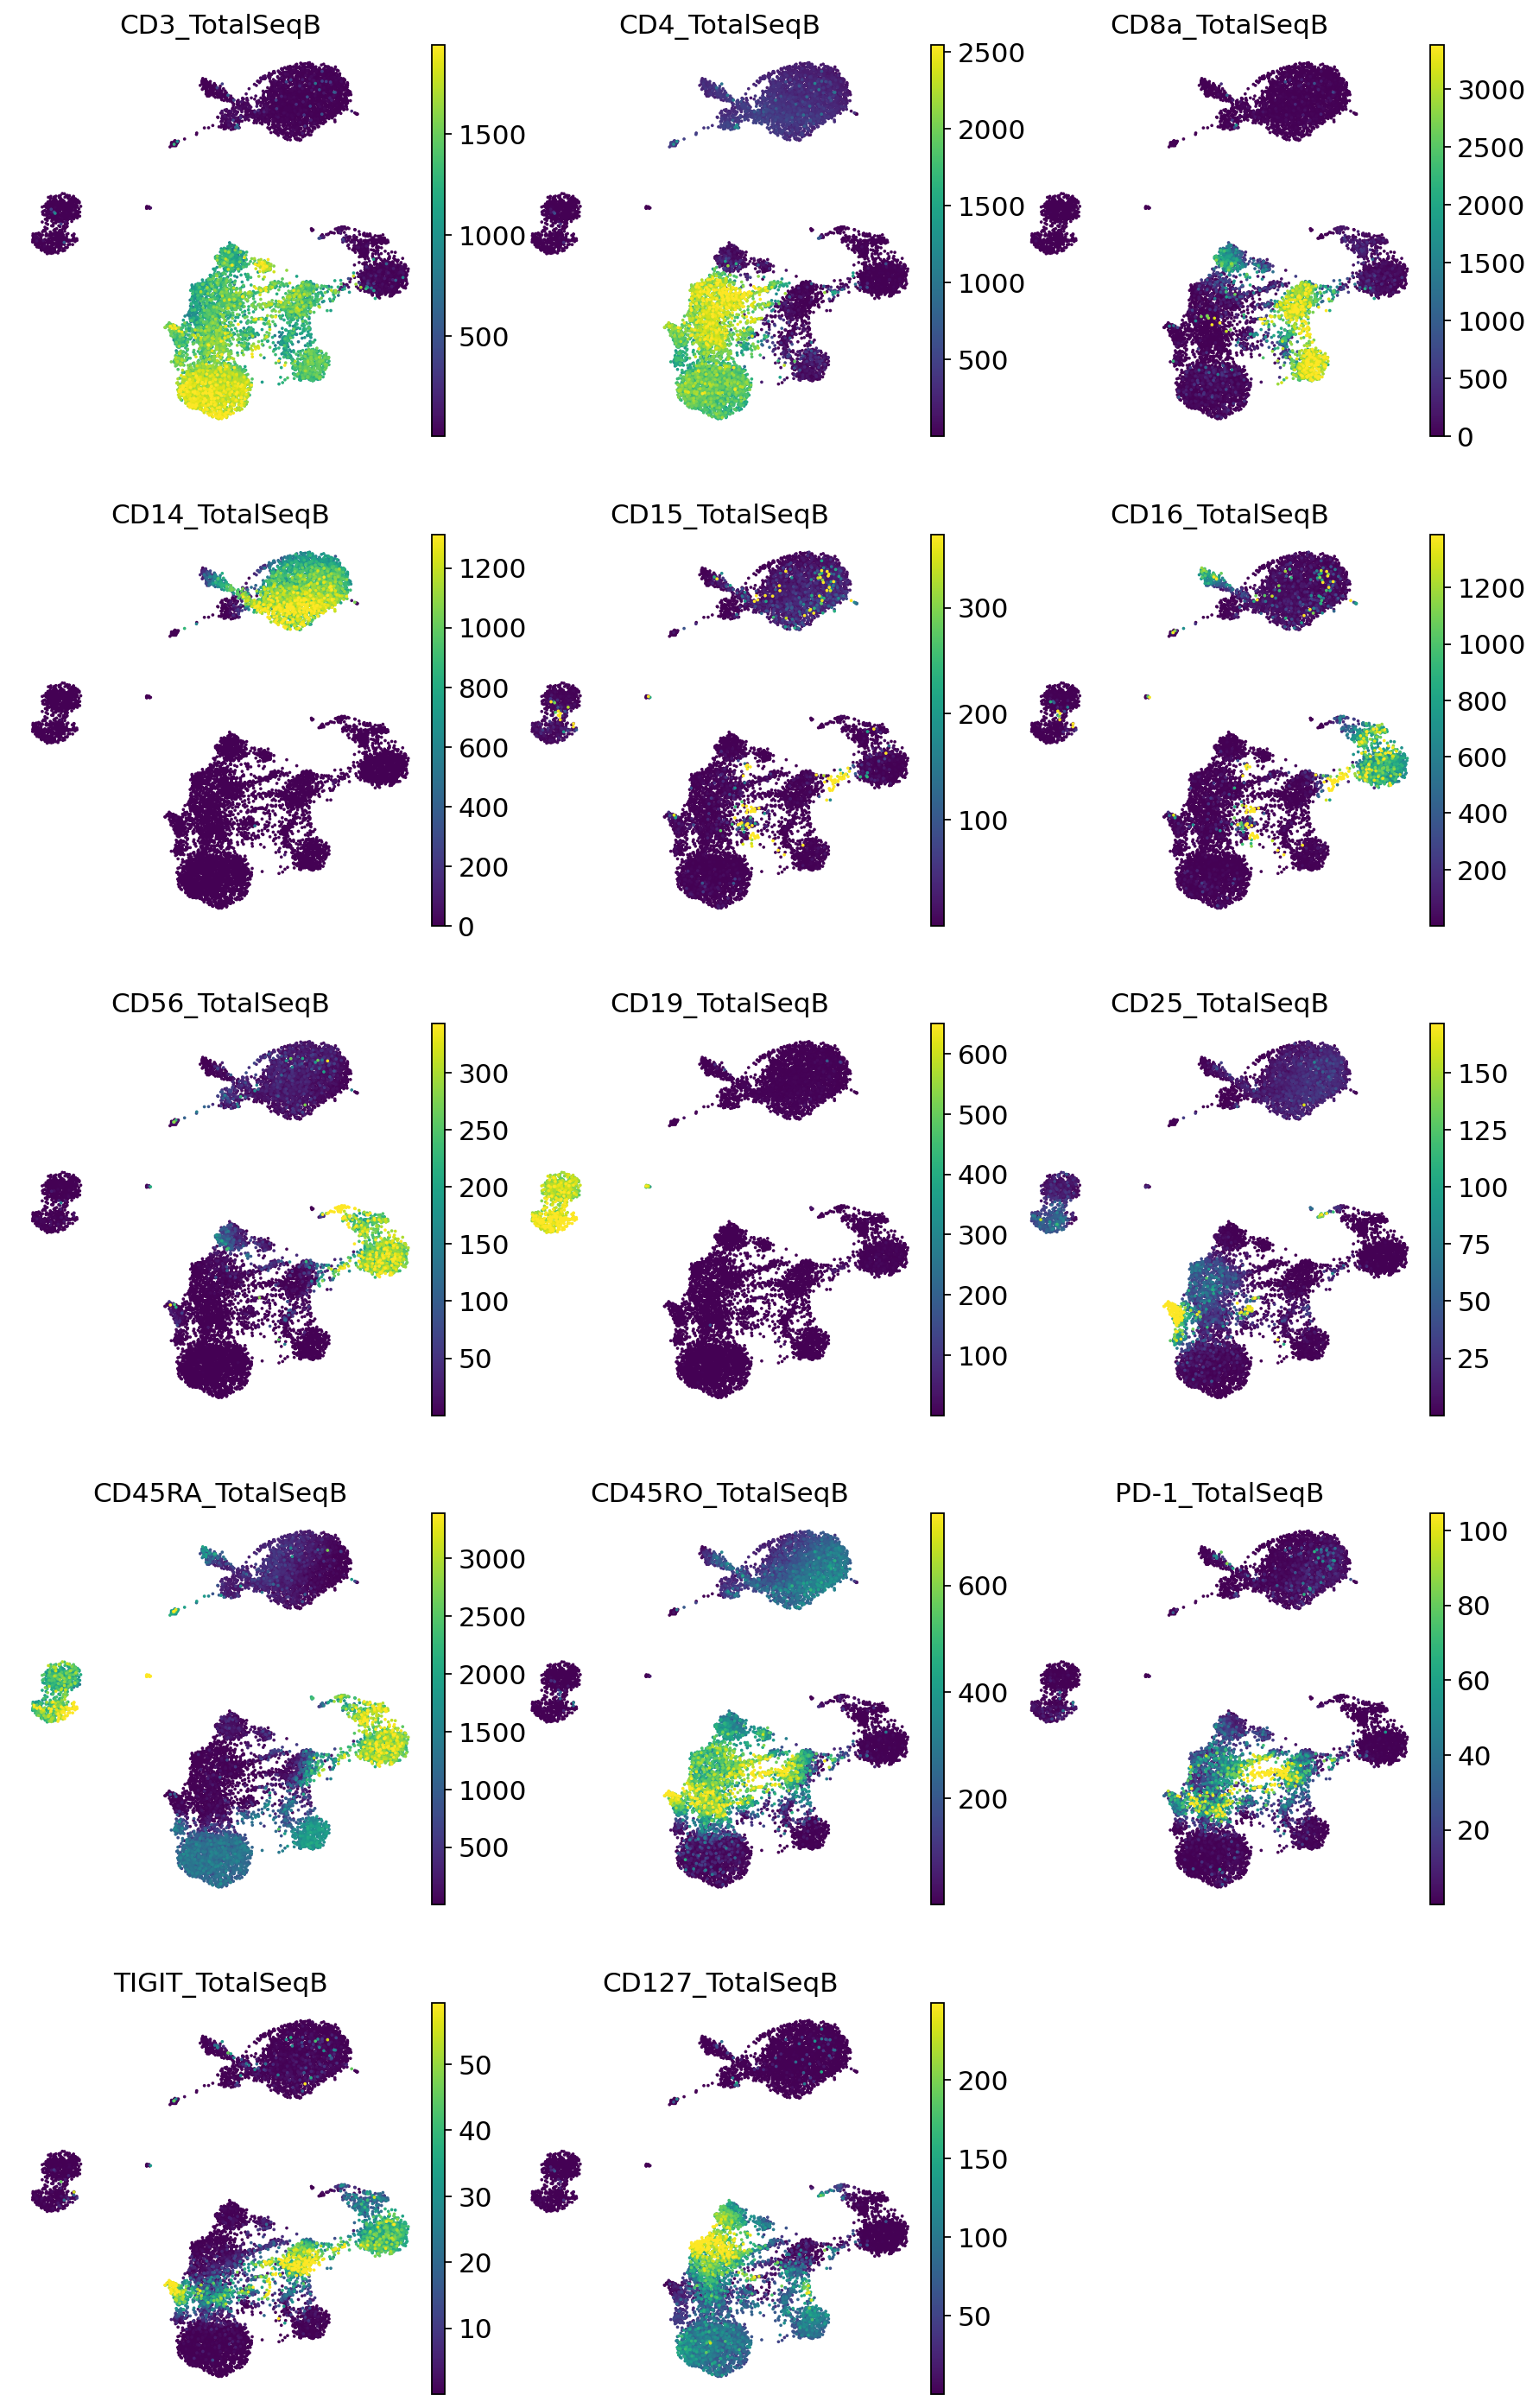

In [16]:
sc.pl.umap(
    pro_adata, 
    color=pro_adata.var_names,
    gene_symbols="protein_names",
    ncols=3, 
    vmax="p99",
    use_raw=False,
    frameon=False,
    wspace=0.1
)

### Visualize probability of foreground

Here we visualize the probability of foreground for each protein and cell (projected on UMAP).
Some proteins are easier to disentangle than others. Some proteins end up being "all background".
For example, CD15 does not appear to be captured well, when looking at the denoised values above we see little localization in the monocytes.

<div class="alert alert-info">

Note

While the foreground probability could theoretically be used to identify cell populations, we recommend using the denoised protein expression, which accounts for the foreground/background probability, but preserves the dynamic range of the protein measurements. Consequently, the denoised values are on the same scale as the raw data and it may be desirable to take a transformation like log or square root.

</div>

By viewing the foreground probability, we can get a feel for the types of cells in our dataset. For example, it's very easy to see a population of monocytes based on the CD14 foregroud probability.

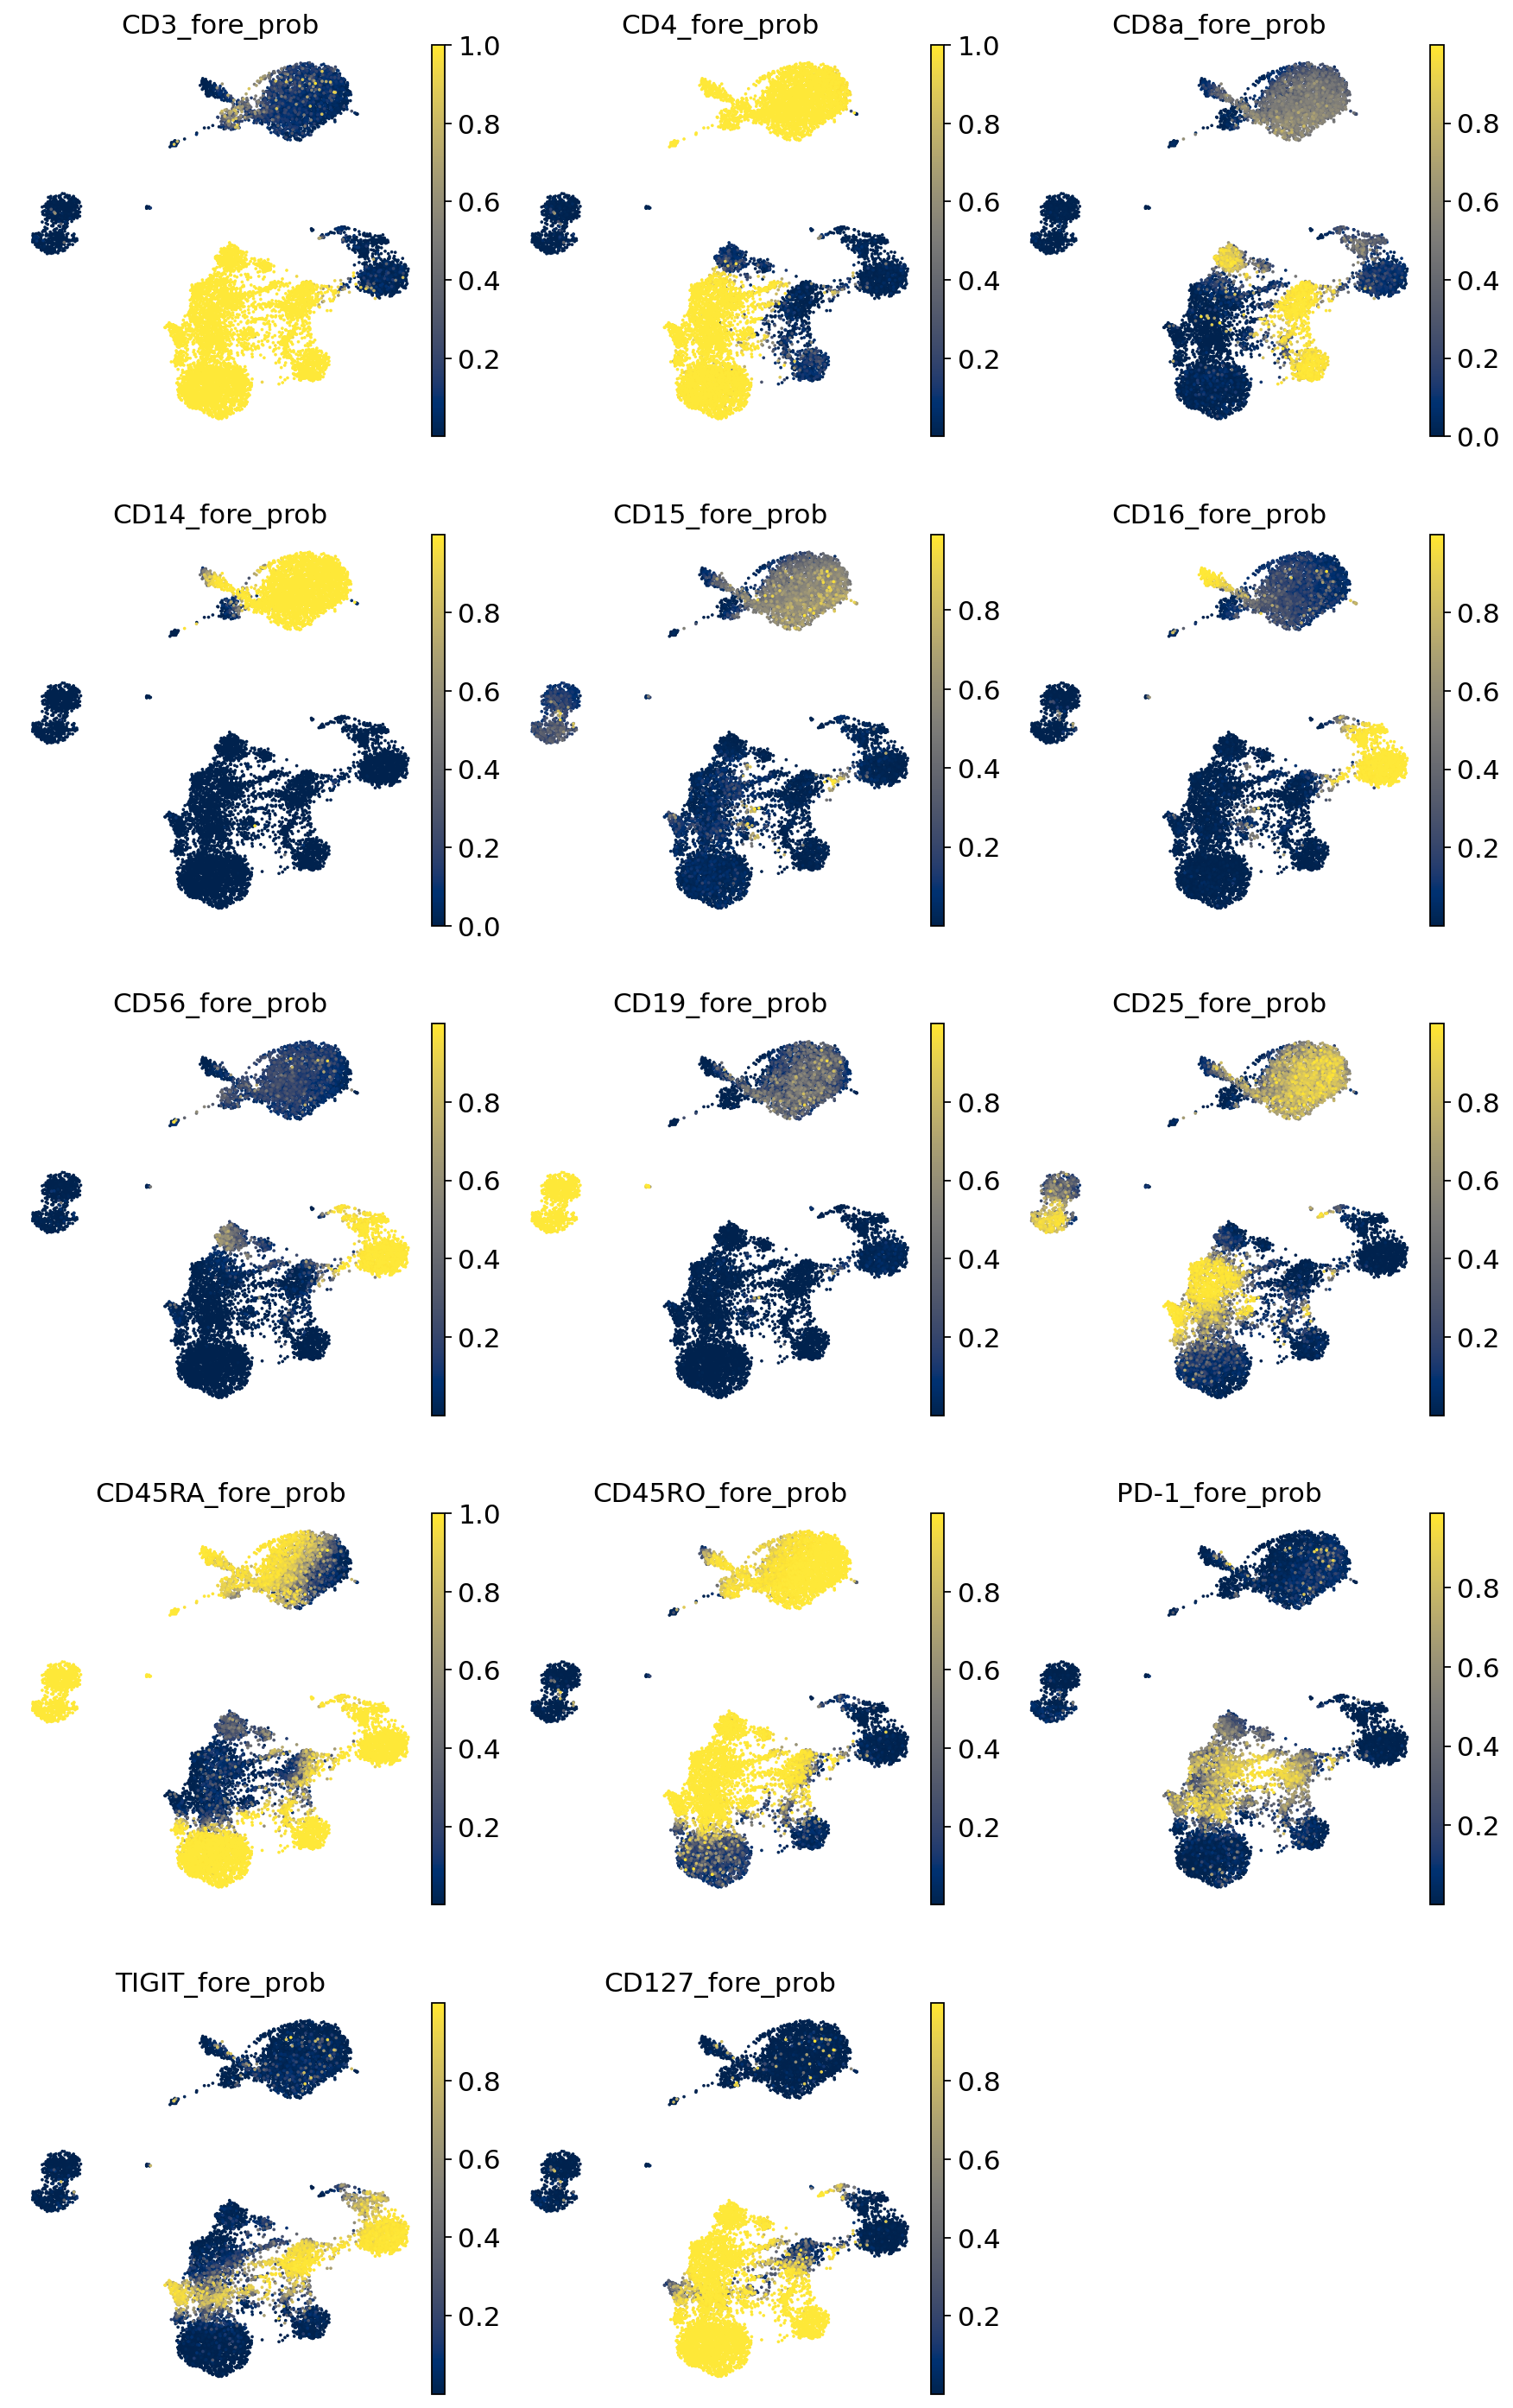

In [17]:
sc.pl.umap(
    pro_adata,
    color=["{}_fore_prob".format(p) for p in parsed_protein_names],
    ncols=3,
    color_map="cividis",
    frameon=False,
    wspace=0.1
)

## Differential expression

Here we do a one-vs-all DE test, where each cluster is tested against all cells not in that cluster. The results for each of the one-vs-all tests is concatenated into one DataFrame object. Inividual tests can be sliced using the "comparison" column. Genes and proteins are included in the same DataFrame.

<div class="alert alert-info">

Important

We do not recommend using totalVI denoised values in other differential expression tools, as denoised values are a summary of a random quantity. The totalVI DE test takes into account the full uncertainty of the denoised quantities.

</div>

In [18]:
de_df = vae.differential_expression(
        groupby="leiden_totalVI", 
        delta=0.5,
        batch_correction=True
)
de_df.head(5)

DE...: 100%|██████████| 18/18 [00:51<00:00,  2.84s/it]


proba_de  proba_not_de  bayes_factor    scale1        scale2  \
WLS        0.9990        0.0010      6.906745  0.000053  3.826878e-07   
S100A12    0.9988        0.0012      6.724225  0.003306  2.673053e-05   
ALDH1A1    0.9986        0.0014      6.569875  0.000246  2.337148e-06   
C9ORF47    0.9986        0.0014      6.569875  0.000020  1.645234e-07   
MARC1      0.9984        0.0016      6.436144  0.000119  8.664902e-07   

         pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
WLS               0.0    0.5  8.946897    9.093779  2.319537  ...   0.144357   
S100A12           0.0    0.5  8.952673    9.097330  2.377829  ...   9.262467   
ALDH1A1           0.0    0.5  8.541307    8.669662  2.453426  ...   0.661417   
C9ORF47           0.0    0.5  7.950605    8.018548  2.285622  ...   0.058868   
MARC1             0.0    0.5  8.722045    8.836887  2.555686  ...   0.302962   

         raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
WLS       0.001589               0.124484               0.001589   
S100A12   0.073943               0.944882               0.027255   
ALDH1A1   0.005378               0.394076               0.004522   
C9ORF47   0.000122               0.049119               0.000122   
MARC1     0.002322               0.234721               0.002078   

         raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
WLS                  0.497803              0.003369            True   
S100A12             34.482307              0.228318            True   
ALDH1A1              2.366598              0.019742            True   
C9ORF47              0.197639              0.000493            True   
MARC1                1.172208              0.007004            True   

         comparison  group1 group2  
WLS       0 vs Rest       0   Rest  
S100A12   0 vs Rest       0   Rest  
ALDH1A1   0 vs Rest       0   Rest  
C9ORF47   0 vs Rest       0   Rest  
MARC1     0 vs Rest       0   Rest  

[5 rows x 22 columns]

Now we filter the results such that we retain features above a certain Bayes factor (which here is on the natural log scale) and genes with greater than 10% non-zero entries in the cluster of interest.

In [19]:
filtered_pro = {}
filtered_rna = {}
cats = adata.obs.leiden_totalVI.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]
    cell_type_df = cell_type_df.sort_values("lfc_median", ascending=False)

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 0]

    pro_rows = cell_type_df.index.str.contains('TotalSeqB')
    data_pro = cell_type_df.iloc[pro_rows]
    data_pro = data_pro[data_pro["bayes_factor"] > 0.7]

    data_rna = cell_type_df.iloc[~pro_rows]
    data_rna = data_rna[data_rna["bayes_factor"] > 3]
    data_rna = data_rna[data_rna["non_zeros_proportion1"] > 0.1]

    filtered_pro[c] = data_pro.index.tolist()[:3]
    filtered_rna[c] = data_rna.index.tolist()[:2]

We can also use general scanpy visualization functions

In [20]:
sc.tl.dendrogram(adata, groupby="leiden_totalVI", use_rep="X_totalVI")
sc.tl.dendrogram(pro_adata, groupby="leiden_totalVI", use_rep="X_totalVI")

/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:510: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  matplotlib.colorbar.ColorbarBase(


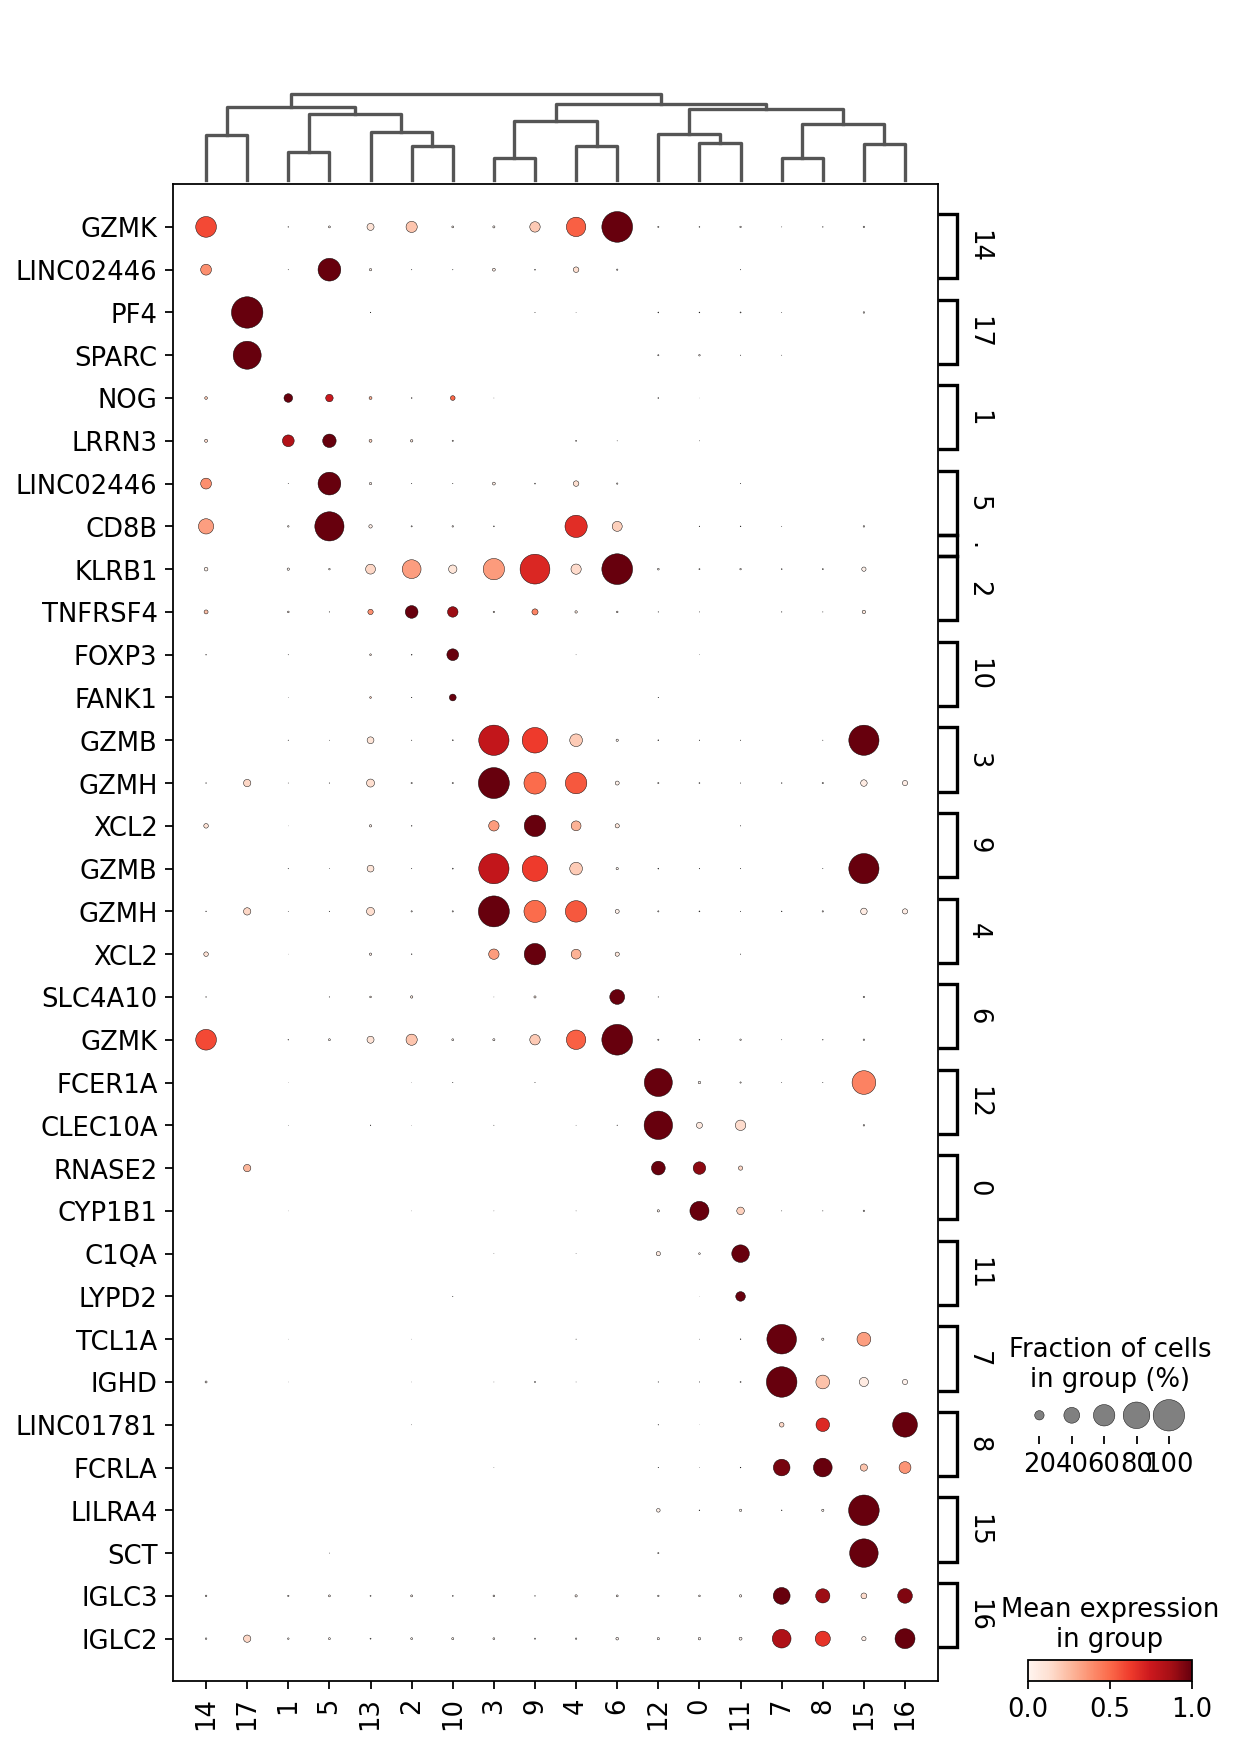

In [21]:
sc.pl.dotplot(
    adata, 
    filtered_rna, 
    groupby="leiden_totalVI", 
    dendrogram=True,
    standard_scale="var",
    swap_axes=True
)

Matrix plot displays totalVI denoised protein expression per leiden cluster.

/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/scanpy/plotting/_matrixplot.py:254: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = ax.pcolor(_color_df, **kwds)
/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/scanpy/plotting/_baseplot_class.py:510: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  matplotlib.colorbar.ColorbarBase(


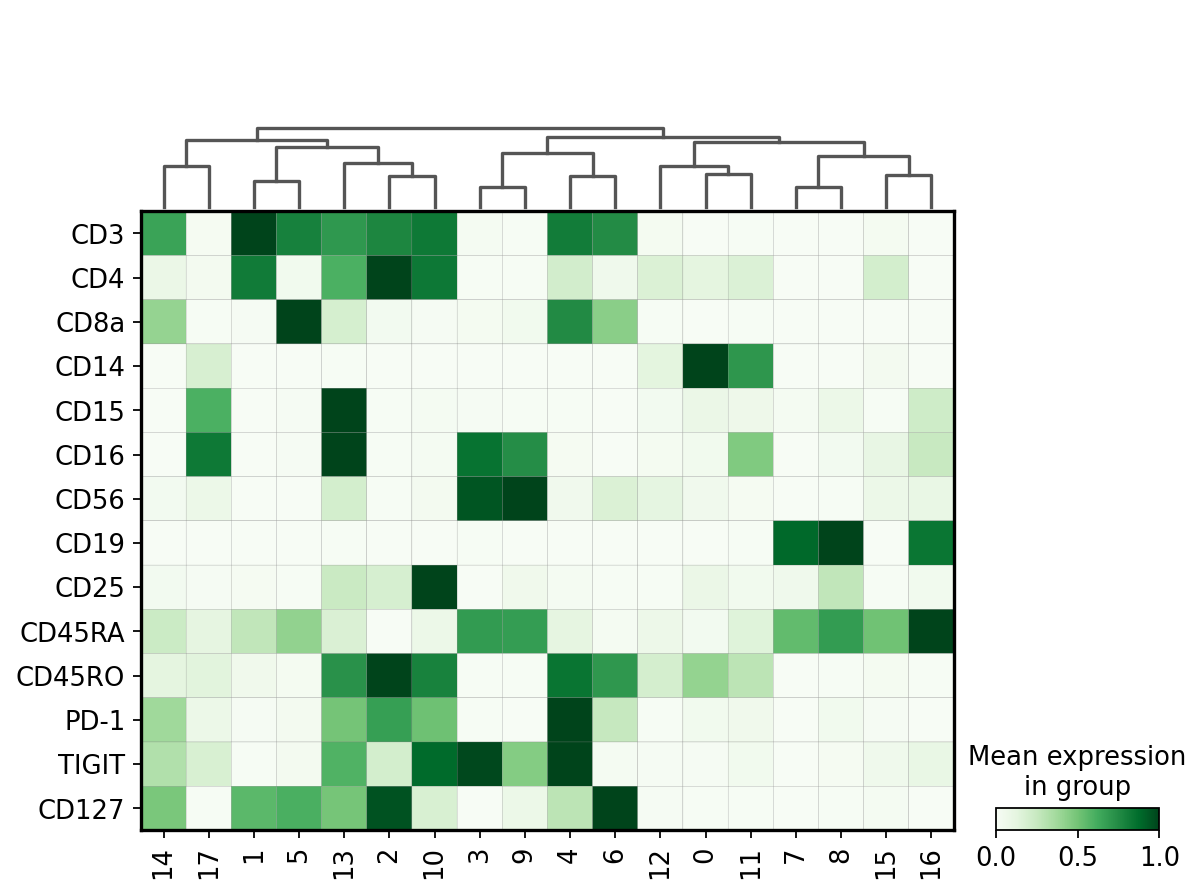

In [22]:
sc.pl.matrixplot(
    pro_adata,
    pro_adata.var["protein_names"],
    groupby="leiden_totalVI",
    gene_symbols="protein_names",
    dendrogram=True,
    swap_axes=True,
    use_raw=False, # use totalVI denoised
    cmap="Greens",
    standard_scale="var"
)

This is a selection of some of the markers that turned up in the RNA DE test. 

/data/yosef2/users/jhong/miniconda3/envs/v15/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:444: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  pl.colorbar(cax, ax=ax, pad=0.01, fraction=0.08, aspect=30)


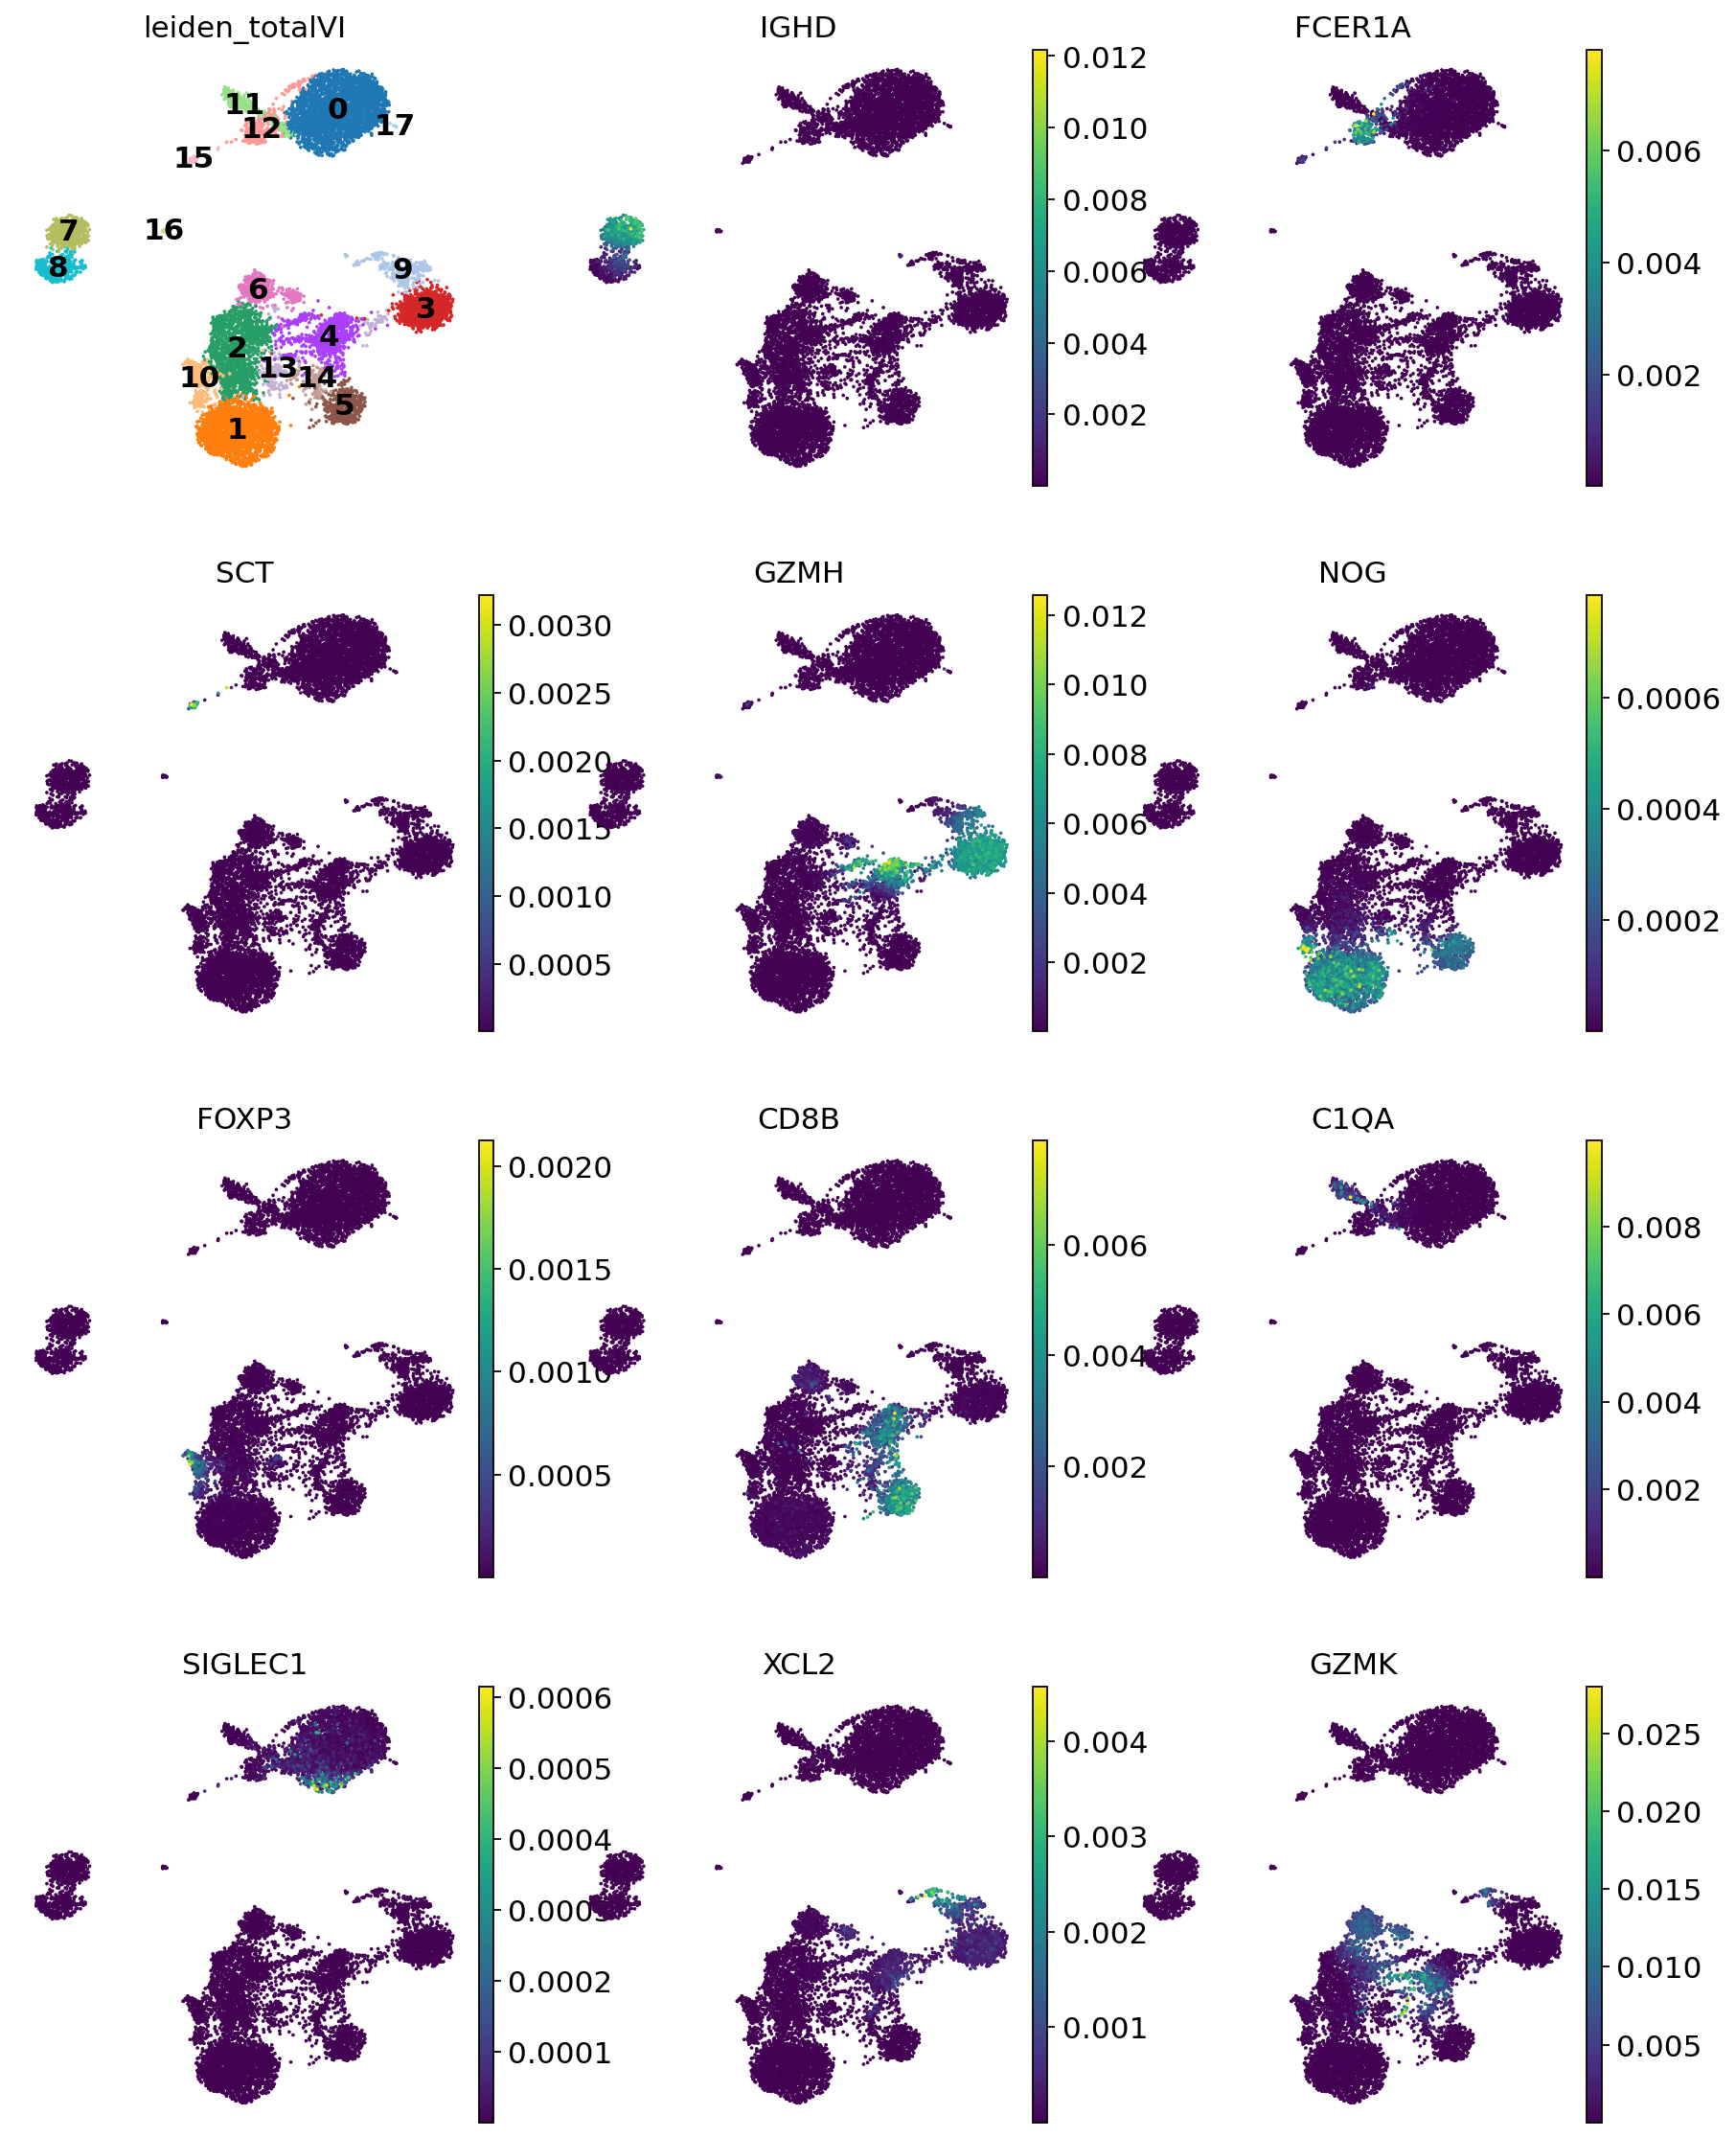

In [23]:
sc.pl.umap(
    adata, 
    color=[
           "leiden_totalVI", 
           "IGHD", 
           "FCER1A", 
           "SCT", 
           "GZMH", 
           "NOG", 
           "FOXP3", 
           "CD8B",
           "C1QA", 
           "SIGLEC1", 
           "XCL2", 
           "GZMK", 
           ], 
    legend_loc="on data",
    frameon=False,
    ncols=3,
    layer="denoised_rna",
    wspace=0.1
)